In [1]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolMarine, AerosolBoreal

#!pip install -e ~/Research/PySDM
import PySDM
print(PySDM.__file__)
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
import os
from matplotlib import pyplot
import matplotlib
from joblib import Parallel, delayed, parallel_backend

/Users/claresinger/Research/PySDM/PySDM/__init__.py


In [2]:
updraft_list = np.geomspace(0.1, 10, 2)
forg_list = np.linspace(0.1, 0.9, 2)

subplot_list = ["a","b","c","d"]
models = ('bulk', 'film')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

In [3]:
def compute(key, settings):
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.aerosol_modes_per_cc[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(forg_list) * len(updraft_list)}')
with parallel_backend('loky', n_jobs=-1):
    output = dict(Parallel(verbose=10)(
        delayed(compute)(subplot+f"_w{w:.2f}_f{Forg:.2f}_"+model, Settings(
            dz = 0.1 * si.m,
            n_sd_per_mode = 100,
            model = model,
            aerosol = {
                "a": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["a"]),
                "b": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["b"]),
                "c": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["c"]),
                "d": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["d"])
            }[subplot],
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity
        ))
        for w in updraft_list
        for Forg in forg_list
        for subplot in subplot_list
        for model in models
    ))

tasks scheduled: 32


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:  2.8min remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  2.9min finished


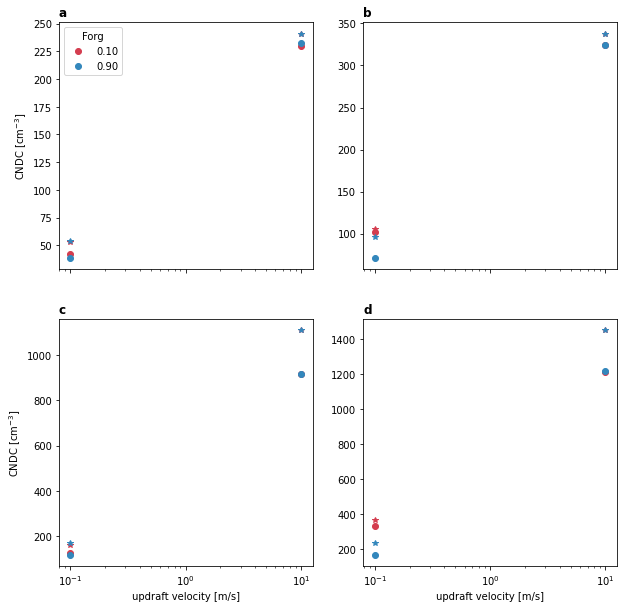

In [4]:
fig,axes = pyplot.subplots(2,2,figsize=(10,10),sharex=True,sharey=False)

f0 = open("testPySDM_Marine_0.txt","w")
f1 = open("testPySDM_Marine_1.txt","w")

f0.write("parcel disp = 200.00 \n")
f0.write("updraft (m/s), forg, CDNC (cm-3) \n")
f1.write("parcel disp = 200.00 \n")
f1.write("updraft (m/s), forg, CDNC (cm-3) \n")

for k,subplot in enumerate(subplot_list):
    for i,w in enumerate(updraft_list):
        for j,Forg in enumerate(forg_list):
            key = subplot+f"_w{w:.2f}_f{Forg:.2f}_"
            var = 'n_c_cm3'
            z = np.array(output[key+"film"]['z'])
            CDNC_film = np.array(output[key+"film"][var])
            CDNC_bulk = np.array(output[key+"bulk"][var])

            ax = axes.flatten()[k]
            ax.set_title(subplot, loc="left", weight="bold")

            cmap = matplotlib.cm.get_cmap('Spectral')
            if i == 0:
                ax.plot(w, CDNC_bulk[-1], 'o', color=cmap(Forg), label="{:.2f}".format(Forg))
                ax.plot(w, CDNC_film[-1], '*', color=cmap(Forg))
            else:
                ax.plot(w, CDNC_bulk[-1], 'o', color=cmap(Forg))
                ax.plot(w, CDNC_film[-1], '*', color=cmap(Forg))

            if subplot == "b":
                f0.write(f"{w:.2e}, {Forg:.2f}, {CDNC_bulk[-1]:.2f} \n")
                f1.write(f"{w:.2e}, {Forg:.2f}, {CDNC_film[-1]:.2f} \n")

            ax.set_xscale("log")
            if k == 0:
                ax.legend(title="Forg")
                ax.set_ylabel("CNDC [cm$^{-3}$]")
            if k == 2:
                ax.set_ylabel("CNDC [cm$^{-3}$]")
            if k > 1:
                ax.set_xlabel("updraft velocity [m/s]")
                
pyplot.show()

f0.close()
f1.close()